# Bounds on Lyapunov exponents of linked twist maps

## Packages and libraries

In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Definition and basic dynamics of the map

### Linked twist map with parameter $p$

In [34]:
# Function takes a point (x,y) as an array xy and
# parameter p in [0,1], and returns the H(x,y)
# and the Jacobian DH(x,y)

def ltm(xy,p):
    
    jac = np.eye(2)
    if xy[1]<p:
        xy[0] = np.modf(xy[0]+xy[1]/p)[0]
        jac = np.dot(np.array([[1.0,1/p],[0.0,1.0]]),jac)
    if xy[0]<p:
        xy[1] = np.modf(xy[1]+xy[0]/p)[0]
        jac = np.dot(np.array([[1.0,0.0],[1/p,1.0]]),jac)
    return xy,jac 

The map is ergodic, and indeed mixing, for all $p$, as illustrated by a scatter plot of an orbit of a random initial condition. Note the accumulation of points near the boundaries, indicating non-hyperbolic behaviour contributing to a slower mixing rate and a lower Lyapunov exponent $\lambda$.

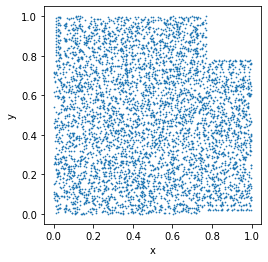

In [47]:
max_iterations = 5000
p = 0.8

xpts, ypts = [],[]
xy = np.array([np.random.random(),np.random.random()])
for i in range(max_iterations):
    xy = ltm(xy,p)[0]
    xpts.append(xy[0])
    ypts.append(xy[1])

plt.xlabel('x')
plt.ylabel('y')
axes=plt.gca()
axes.set_aspect('equal')
plt.scatter(xpts,ypts,s=0.5)

A standard algorithm based on Gram-Schmidt orthonormalisation to approximate the Lyapunov exponents. See Parker & Chua; <cite>Practical Numerical Algorithms for Chaotic Systems</cite>

In [108]:
# Takes the map f, an initial condition xy, the number of iterations k_max, and a
# parameter p

def le(f,xy,k_max,p):

    u = np.eye(2)
    v = np.zeros([2,2])
    le = np.array([0.0,0.0])
    le_old = np.array([100.0,100.0])
    sum = np.array([0.0,0.0])
    k = 0
    while k<k_max:
        k += 1
        le_old[:] = le[:]
        tt = f(xy,p)
        xy, delta_x = tt[0],np.dot(tt[1],u)
        for i in range(2):
            v[:,i] = delta_x[:,i]
            if i==1:
                v[:,i] -= np.dot(v[:,i],u[:,0])*u[:,0]
            u[:,i] = v[:,i]/np.linalg.norm(v[:,i])
            sum[i] += np.log(np.linalg.norm(v[:,i]))
            le[i] = sum[i]/k
    return le

The Cat Map is an LTM with $p=1$, and we can check the algorithm produces the analytically correct value of $\lambda = \log((3+\sqrt{5})/2)$:

In [109]:
print('\u03BB \u2248',le(ltm,np.array([0.123,0.321]),10**4,1.0)[0])
print('\u03BB =',np.log((np.sqrt(5)+3)/2))

# Typically 3 d.p.s of accuracy in 10^4 iterates

λ ≈ 0.9623593535801427
λ = 0.9624236501192069


For smaller values of $p$ the Lyapunov exponent reduces, due to the non-hyperbolic behaviour near boundaries:

In [66]:
print('\u03BB \u2248',le(ltm,np.array([0.123,0.321]),10**4,0.8)[0])
print('\u03BB \u2248',le(ltm,np.array([0.123,0.321]),10**4,0.6)[0])
print('\u03BB \u2248',le(ltm,np.array([0.123,0.321]),10**4,0.4)[0])
print('\u03BB \u2248',le(ltm,np.array([0.123,0.321]),10**4,0.2)[0])

λ ≈ 0.923589738675025
λ ≈ 0.8779322754711142
λ ≈ 0.819245254209546
λ ≈ 0.6340248108121671


## Rigorous bounds via the return time partition

Return time partition elements: $R_{i,j}$ corresponds to $H_S = G^j F^i$. The Lebesgue measure of these sets have been divided by $\mu (S) = p^2$, giving the conditional measure $\mu_S$.

In [69]:
# Conditional measures of return time partition elements from lemma 2

def R11(p):
    return 2*p**3/(1+p**2)

def R12(p):
    return (-3*p**4+2*p**3+2*p-1)/(2*p*(1+p**2))

def R21(p):
    return R12(p)

def R22(p):
    return ((1-p)**2)/(1+p**2)

The infinite tail of the return time partition

In [68]:
# Conditional measures of return time partition elements from lemma 3

def R1n(p,n):
    numerator = 2*(1-p)**2
    denominator = n*p*(n-1)*(n-2)
    return numerator/denominator
    
def Rn1(p,n):
    return R1n(p,n)

Note that these should add up to 1, as we're looking at the conditional measure on $S$.

In [70]:
# sum the areas of the partition elements
def p_check(p):
    total_area = R11(p) + R12(p) + R21(p) + R22(p)
    for n in range(3,10**5):
        total_area += R1n(p,n)+Rn1(p,n)
    return total_area

In [71]:
print(p_check(0.7),p_check(0.8),p_check(0.9),p_check(1.0))

0.9999999999743125 0.9999999999899633 0.999999999997926 1.0


We define functions for the minimum and maximum growth in tangent vector for $\ell_1$, $\ell_2$ and $\ell_{\infty}$ norms, as given in lemma 1:

In [72]:
def L1max(a,b,p):
    return 1+a/p+a*b/p**2

def L1min(a,b,p):
    return 1+(a*b+p*a+p**2*b)/(p**2*(1+p))

In [73]:
def Linfmax(a,b,p):
    return 1+b+a*b/p**2

def Linfmin(a,b,p):
    return 1+a*b/p**2

In [74]:
def L2min(a,b,p):
    m1 = ((p+a/p)**2+(1+b+a*b/p**2)**2)/(1+p**2)
    m2 = (a/p)**2+(1+a*b/p**2)**2
    return np.sqrt(np.min([m1,m2]))

def L2max(a,b,p):
    Mab = np.array([[1,a/p],[b/p,1+a*b/p**2]])
    MM = np.dot(Mab,Mab.T)
    return np.sqrt(np.max(np.linalg.eigvals(MM)))

We need to normalise by the expected number of blocks in $n$ iterates:

In [75]:
def ns(p):
    return 2/p-1

Here we construct the sum of area of partition elements multiplied by tangent vector growth as in theorem 2:

In [77]:
def L1_lower_bound(p):
    tot = R11(p)*np.log(L1min(1,1,p))+R12(p)*np.log(L1min(1,2,p))+R21(p)*np.log(L1min(2,1,p))
    tot += R22(p)*np.log(L1min(2,2,p))
    for a in range(3,100):
        tot += 2*R1n(p,a)*np.log(L1min(1,a,p))
    return tot/ns(p)

def L1_upper_bound(p):
    tot = R11(p)*np.log(L1max(1,1,p))+R12(p)*np.log(L1max(1,2,p))+R21(p)*np.log(L1max(2,1,p))
    tot += R22(p)*np.log(L1max(2,2,p))
    for a in range(3,100):
        tot += 2*R1n(p,a)*np.log(L1max(1,a,p))
    return tot/ns(p)

def Linf_lower_bound(p):
    tot = R11(p)*np.log(Linfmin(1,1,p))+R12(p)*np.log(Linfmin(1,2,p))+R21(p)*np.log(Linfmin(2,1,p))
    tot += R22(p)*np.log(Linfmin(2,2,p))
    for a in range(3,10):
        tot += 2*R1n(p,a)*np.log(Linfmin(1,a,p))
    return tot/ns(p)

def Linf_upper_bound(p):
    tot = R11(p)*np.log(Linfmax(1,1,p))+R12(p)*np.log(Linfmax(1,2,p))+R21(p)*np.log(Linfmax(2,1,p))
    tot += R22(p)*np.log(Linfmax(2,2,p))
    for a in range(3,100):
        tot += 2*R1n(p,a)*np.log(Linfmax(1,a,p))
    return tot/ns(p)

def L2_lower_bound(p):
    tot = R11(p)*np.log(L2min(1,1,p))+R12(p)*np.log(L2min(1,2,p))+R21(p)*np.log(L2min(2,1,p))
    tot += R22(p)*np.log(L2min(2,2,p))
    for a in range(3,100):
        tot += 2*R1n(p,a)*np.log(L2min(1,a,p))
    return tot/ns(p)

def L2_upper_bound(p):
    tot = R11(p)*np.log(L2max(1,1,p))+R12(p)*np.log(L2max(1,2,p))+R21(p)*np.log(L2max(2,1,p))
    tot += R22(p)*np.log(L2max(2,2,p))
    for a in range(3,100):
        tot += 2*R1n(p,a)*np.log(L2max(1,a,p))
    return tot/ns(p)

Previously used the following standard algorithm to compute numerical approximation to $\lambda$ for a range of $p$.

In [118]:
# commented out here as calculation is lengthy
#les = []
#for p in np.arange(0.7,1.0,0.001):
#    les.append(le(ltm,np.array([0.123,0.321]),10**5,p)[0])
#np.savetxt('ltm_les_10E5.dat.txt',les)

Now we load in previously computed values from this procedure:

In [119]:
les = np.loadtxt('ltm_les_10E5.dat.txt')

Populate lists with rigorous bounds:

In [80]:
L1lows = []
L1highs = []
for p in np.arange(0.7,1.0,0.01):
    L1lows.append(L1_lower_bound(p))
    L1highs.append(L1_upper_bound(p))
    
L2lows = []
L2highs = []
for p in np.arange(0.7,1.0,0.01):
    L2lows.append(L2_lower_bound(p))
    L2highs.append(L2_upper_bound(p))    
    
Linflows = []
Linfhighs = []
for p in np.arange(0.7,1.0,0.01):
    Linflows.append(Linf_lower_bound(p))
    Linfhighs.append(Linf_upper_bound(p))

Another bound, from D'Alessandro et al., IEEE <cite>Transactions on Automatic Control</cite> (1999), maximises the topological entropy and hence the Lyapunov exponent, by the Pesin Entropy Formula. 

In [81]:
def top_entropy_bound(p):
    return np.log(1+(1/2*p**2)+np.sqrt((1/p**2)+(1/4*p**2)))

Plot the bounds and numerical values:

In [82]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('xtick', labelsize=16) 
rc('ytick', labelsize=16)

Produce figure 5(a):

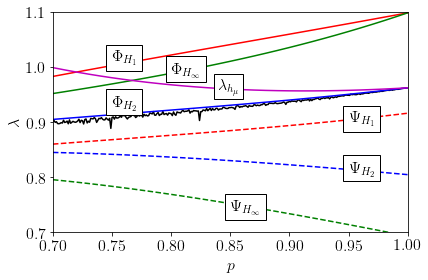

In [120]:
ps = np.arange(0.7,1.0,0.01)
pss = np.arange(0.7,1.0,0.001)
pl.xlabel(r'$p$',fontsize=16)
pl.ylabel(r'$\lambda$',fontsize=16)
pl.xlim([0.7,1.0])
pl.ylim([0.7,1.1])

pl.plot(pss,les,'k',label=r'$\lambda_{\mbox{num}}$')
pl.plot(ps,L1lows,'r--',label=r'$\Psi_{H_1}$')
pl.plot(ps,L1highs,'r',label=r'$\Phi_{H_1}$')
pl.plot(ps,L2lows,'b--',label=r'$\Psi_{H_2}$')
pl.plot(ps,L2highs,'b',label=r'$\Phi_{H_2}$')
pl.plot(ps,Linflows,'g--',label=r'$\Psi_{H_{\infty}}$')
pl.plot(ps,Linfhighs,'g',label=r'$\Phi_{H_{\infty}}$')
pl.plot(ps,[top_entropy_bound(pp) for pp in ps],'m',label=r'$\lambda_{h_{\mu}}$')
    
# add labels    
pl.text(0.85, 0.74, r'$\Psi_{H_\infty}$', bbox=dict(boxstyle='square,pad=0.35',facecolor='white', alpha=1.0), fontsize=16)
pl.text(0.95, 0.81, r'$\Psi_{H_2}$', bbox=dict(boxstyle='square,pad=0.35',facecolor='white', alpha=1.0), fontsize=16)
pl.text(0.95, 0.9, r'$\Psi_{H_1}$', bbox=dict(boxstyle='square,pad=0.35',facecolor='white', alpha=1.0), fontsize=16)
pl.text(0.75, 1.01, r'$\Phi_{H_1}$', bbox=dict(boxstyle='square,pad=0.35',facecolor='white', alpha=1.0), fontsize=16)
pl.text(0.75, 0.93, r'$\Phi_{H_2}$', bbox=dict(boxstyle='square,pad=0.35',facecolor='white', alpha=1.0), fontsize=16)
pl.text(0.8, 0.99, r'$\Phi_{H_\infty}$', bbox=dict(boxstyle='square,pad=0.35',facecolor='white', alpha=1.0), fontsize=16)
pl.text(0.84, 0.96, r'$\lambda_{h_\mu}$', bbox=dict(facecolor='white', alpha=1.0), fontsize=16)
    
pl.tight_layout()

pl.savefig('ltm_simple_bounds_bw.pdf')

Choose the tightest bounds and zoom in to plot figure 5(b):

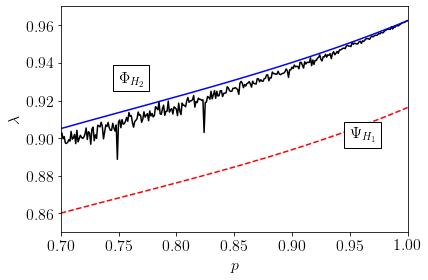

In [115]:
ps = np.arange(0.7,1.0,0.01)
pss = np.arange(0.7,1.0,0.001)
pl.xlabel(r'$p$',fontsize=16)
pl.ylabel(r'$\lambda$',fontsize=16)
pl.xlim([0.7,1.0])
pl.ylim([0.85,0.97])

pl.plot(pss,les,'k',label=r'$\lambda_{\mbox{num}}$')
pl.plot(ps,L1lows,'r--',label=r'$\Psi_{H_1}$')
pl.plot(ps,L2highs,'b',label=r'$\Phi_{H_2}$')

pl.text(0.95, 0.9, r'$\Psi_{H_1}$', bbox=dict(boxstyle='square,pad=0.35',facecolor='white', alpha=1.0), fontsize=16)
pl.text(0.75, 0.93, r'$\Phi_{H_2}$', bbox=dict(boxstyle='square,pad=0.35',facecolor='white', alpha=1.0), fontsize=16)
    
pl.tight_layout()

pl.savefig('ltm_simple_bounds_zoom.pdf')

## Tightening the bounds

We improve the bounds, as in section 5, by considering which matrices $M_{a_2,b_2}$ can precede each $M_{a_1,b_1}$ and the partition $R_{a_2,b_2} \cap H^{-1}_S (R_{a_1,b_1})$. Following the numbering in figure 4 we have the areas of partition elements given by:

In [87]:
def improved_mu_R(a2,b2,a1,b1,p):
    
    if (a2,b2,a1,b1) == (1,1,1,1):
        return 2*p*(6*p**8 + 14*p**6 - 6*p**5 + 7*p**4 - 8*p**3 + 3*p**2 - 2*p + 1)/(2*p**8 + 9*p**6 + 12*p**4 + 6*p**2 + 1)
    elif (a2,b2,a1,b1) == (2,1,1,1):
        return -(10*p**10 + 4*p**9 + 9*p**8 - 10*p**7 + p**6 - 24*p**5 + 14*p**4 - 12*p**3 + 9*p**2 - 2*p + 1)/(4*p**9 + 18*p**7 + 24*p**5 + 12*p**3 + 2*p)
    elif (a2,b2,a1,b1) == (1,2,1,1):
        return -(8*p**6 - 4*p**5 - 6*p**3 + p**2 + 1)/(4*p**5 + 6*p**3 + 2*p)
    elif (a2,b2,a1,b1) == (2,2,1,1):
        return (-p**3 + 4*p**2 - 5*p + 2)/(2*(p**2 + 1))
    elif (a2,b2,a1,b1) == (1,1,2,1):
        return -(8*p**6 - 4*p**5 - 6*p**3 + p**2 + 1)/(4*p**5 + 6*p**3 + 2*p)
    elif (a2,b2,a1,b1) == (2,1,2,1):
        return 2*p*(p**2 - 2*p + 1)/(2*p**2 + 1)
    elif (a2,b2,a1,b1) == (1,2,2,1):
        return (-p**5 + 4*p**4 - 9*p**3 + 14*p**2 - 12*p + 4)/(p**4 + 5*p**2 + 4)
    elif (a2,b2,a1,b1) == (2,2,2,1):
        return p*(p**4 - 4*p**3 + 9*p**2 - 10*p + 4)/(2*(p**4 + 5*p**2 + 4))
    elif (a2,b2,a1,b1) == (1,1,1,2):
        return -(10*p**10 + 4*p**9 + 9*p**8 - 10*p**7 + p**6 - 24*p**5 + 14*p**4 - 12*p**3 + 9*p**2 - 2*p + 1)/(4*p**9 + 18*p**7 + 24*p**5 + 12*p**3 + 2*p)
    elif (a2,b2,a1,b1) == (2,1,1,2):
        return 4*p**2*(p**2 - 2*p + 1)/(p**4 + 3*p**2 + 1)
    elif (a2,b2,a1,b1) == (1,2,1,2):
        return 2*p*(p**2 - 2*p + 1)/(2*p**2 + 1)
    elif (a2,b2,a1,b1) == (1,1,2,2):
        return (-p**3 + 4*p**2 - 5*p + 2)/(2*(p**2 + 1))
    elif (a2,b2,a1,b1) == (1,2,2,2):
        return p*(p**4 - 4*p**3 + 9*p**2 - 10*p + 4)/(2*(p**4 + 5*p**2 + 4))
    elif (a2,b2,a1,b1) == (2,2,2,2):
        return p**2*(p**2 - 2*p + 1)/(p**4 + 5*p**2 + 4)
    else:
        return 0.0

The uncountable regions $R_{1,1,1,n}$ and $R_{n,1,1,1}$ are the same as $R_{1,n}$ and $R_{n,1}$ from earlier, since each of these do intersect with only one image of a partition element:

In [88]:
def improved_uncountable(n,p):   
    return R1n(p,n) 

Again we check that the areas of the partition elements sum to 1:

In [89]:
def check_improved_partition(p):
    tot = 0.0
    for a2 in [1,2]:
        for b2 in [1,2]:
            for a1 in [1,2]:
                for b1 in [1,2]:
                    tot += improved_mu_R(a2,b2,a1,b1,p)
    for a1 in range(3,10**5):
        tot += 4*improved_uncountable(a1,p)
    return tot
print(check_improved_partition(0.9))

0.999999999995505


Now we need functions which express the maximum and minimum growth of a tangent vectors who see $H_S = G^{b_2}F^{a_2}$ followed by $H_S = G^{b_1}F^{a_1}$. That is, the boundaries of the cone $M_{a_1,b_1}(M_{a_2,b_2}(C))$, giving the improved functions:

In [90]:
def Linfmin_imp(a2,b2,a1,b1,p):
    return 1+(a1*b1/p**2)+(a2*b1/(p**2+a2*b2))

def Linfmax_imp(a2,b2,a1,b1,p):
    return 1+(a1*b1/p**2)+((b1*p**2+a2*b1)/(p**2*(1+b2)+a2*b2))

In [91]:
def L1min_imp(a2,b2,a1,b1,p):
    num = a1*p**3+(a2*b1+a1*b1)*p**2+a2*a1*b2*p+a2*a1*b2*b1
    den = p**2*(a2*b2+a2*p+p**2)
    return 1+num/den

def L1max_imp(a2,b2,a1,b1,p):
    num = b1*p**4+(a1*b2+a1)*p**3+(b2*a1*b1+a2*b1+a1*b1)*p**2+a2*a1*b2*p+a1*a2*b1*b2
    den = p**2*(p**3+(b2+1)*p**2+a2*p+a2*b2)
    return 1+num/den

The $L_2$ norm is slightly different as there is the possibility that $v^2_{\max} \in C$. 

In [92]:
def L2min_imp(a2,b2,a1,b1,p):
    q1 = p/np.sqrt(1+p**2)+a2/(p*np.sqrt(1+p**2))
    q2 = b2*p/(p*np.sqrt(1+p**2))+(1+a2*b2/p**2)/np.sqrt(1+p**2)
    z1 = q1+a1*q2/p
    z2 = b1*q1/p+q2*(1+a1*b1/p**2)
    norm1 = np.sqrt(z1**2+z2**2)/np.sqrt(q1**2+q2**2)

    q1 = a2/p
    q2 = 1+a2*b2/p**2
    z1 = q1+a1*q2/p
    z2 = b1*q1/p+q2*(1+a1*b1/p**2)
    top2 = (a2/p+a1/p+a1*a2*b1/p**3)**2 + (b1*a2/p**2+(1+a1*b1/p**2)*(1+a2*b2/p**2))**2
    norm2 = np.sqrt(z1**2+z2**2)/np.sqrt(q1**2+q2**2)
    return np.min([norm1,norm2])

In [93]:
def L2max_imp(a2,b2,a1,b1,p):
    
# This is either the spectral norm of the matrix Ma1b1, if the eigenvector is in the contracted cone, 
# or if not, the max value at the cone boundaries.

    Mab = np.array([[1,a1/p],[b1/p,1+a1*b1/p**2]])
    MM = np.dot(Mab,Mab.T)
    
    eva, eve = np.linalg.eig(MM)

    idx = eva.argsort()[::-1]   
    eva = eva[idx]
    eve = eve[:,idx]    
                             
    if (eve[0][0]/eve[1][0] >= (a2/p)/(1+(a2*b2/p**2))) and (eve[0][0]/eve[1][0] <= (p+a2/p)/(b2+1+(a2*b2/p**2))):
        return np.sqrt(eva[0])
    
    else:
        q1 = p/np.sqrt(1+p**2)+a2/(p*np.sqrt(1+p**2))
        q2 = b2*p/(p*np.sqrt(1+p**2))+(1+a2*b2/p**2)/np.sqrt(1+p**2)
        z1 = q1+a1*q2/p
        z2 = b1*q1/p+q2*(1+a1*b1/p**2)
        norm1 = np.sqrt(z1**2+z2**2)/np.sqrt(q1**2+q2**2)

        q1 = a2/p
        q2 = 1+a2*b2/p**2
        z1 = q1+a1*q2/p
        z2 = b1*q1/p+q2*(1+a1*b1/p**2)
        top2 = (a2/p+a1/p+a1*a2*b1/p**3)**2 + (b1*a2/p**2+(1+a1*b1/p**2)*(1+a2*b2/p**2))**2
        norm2 = np.sqrt(z1**2+z2**2)/np.sqrt(q1**2+q2**2)
        return np.max([norm1,norm2])    



Here we compute the improved rigorous upper and lower bounds:

In [94]:
def improved_Linf_bounds(p):
    
    totmin, totmax = 0.0, 0.0
    
    for a2 in [1,2]:
        for b2 in [1,2]:
            for a1 in [1,2]:
                for b1 in [1,2]:
                    totmin += improved_mu_R(a2,b2,a1,b1,p)*np.log(Linfmin_imp(a2,b2,a1,b1,p))
                    totmax += improved_mu_R(a2,b2,a1,b1,p)*np.log(Linfmax_imp(a2,b2,a1,b1,p))
                    
    for b2 in range(3,100):
        totmin += improved_uncountable(b2,p)*np.log(Linfmin_imp(1,b2,1,1,p))
        totmax += improved_uncountable(b2,p)*np.log(Linfmax_imp(1,b2,1,1,p))        

    for a2 in range(3,100):
        totmin += improved_uncountable(a2,p)*np.log(Linfmin_imp(a2,1,1,1,p))
        totmax += improved_uncountable(a2,p)*np.log(Linfmax_imp(a2,1,1,1,p))        

    for b1 in range(3,100):
        totmin += improved_uncountable(b1,p)*np.log(Linfmin_imp(1,1,1,b1,p))
        totmax += improved_uncountable(b1,p)*np.log(Linfmax_imp(1,1,1,b1,p))        

    for a1 in range(3,100):
        totmin += improved_uncountable(a1,p)*np.log(Linfmin_imp(1,1,a1,1,p))
        totmax += improved_uncountable(a1,p)*np.log(Linfmax_imp(1,1,a1,1,p))        
                    
    return totmin/((2/p)-1),totmax/((2/p)-1)

In [95]:
def improved_L1_bounds(p):
    
    totmin, totmax = 0.0, 0.0
    
    for a2 in [1,2]:
        for b2 in [1,2]:
            for a1 in [1,2]:
                for b1 in [1,2]:
                    totmin += improved_mu_R(a2,b2,a1,b1,p)*np.log(L1min_imp(a2,b2,a1,b1,p))
                    totmax += improved_mu_R(a2,b2,a1,b1,p)*np.log(L1max_imp(a2,b2,a1,b1,p))
                    
    for b2 in range(3,100):
        totmin += improved_uncountable(b2,p)*np.log(L1min_imp(1,b2,1,1,p))
        totmax += improved_uncountable(b2,p)*np.log(L1max_imp(1,b2,1,1,p))        

    for a2 in range(3,100):
        totmin += improved_uncountable(a2,p)*np.log(L1min_imp(a2,1,1,1,p))
        totmax += improved_uncountable(a2,p)*np.log(L1max_imp(a2,1,1,1,p))        

    for b1 in range(3,100):
        totmin += improved_uncountable(b1,p)*np.log(L1min_imp(1,1,1,b1,p))
        totmax += improved_uncountable(b1,p)*np.log(L1max_imp(1,1,1,b1,p))        

    for a1 in range(3,100):
        totmin += improved_uncountable(a1,p)*np.log(L1min_imp(1,1,a1,1,p))
        totmax += improved_uncountable(a1,p)*np.log(L1max_imp(1,1,a1,1,p))        
                    
    return totmin/((2/p)-1),totmax/((2/p)-1)

In [96]:
def improved_L2_bounds(p):
    
    totmin, totmax = 0.0, 0.0
    
    for a2 in [1,2]:
        for b2 in [1,2]:
            for a1 in [1,2]:
                for b1 in [1,2]:
                    totmin += improved_mu_R(a2,b2,a1,b1,p)*np.log(L2min_imp(a2,b2,a1,b1,p))
                    totmax += improved_mu_R(a2,b2,a1,b1,p)*np.log(L2max_imp(a2,b2,a1,b1,p))
                    
    for b2 in range(3,100):
        totmin += improved_uncountable(b2,p)*np.log(L2min_imp(1,b2,1,1,p))
        totmax += improved_uncountable(b2,p)*np.log(L2max_imp(1,b2,1,1,p))        

    for a2 in range(3,100):
        totmin += improved_uncountable(a2,p)*np.log(L2min_imp(a2,1,1,1,p))
        totmax += improved_uncountable(a2,p)*np.log(L2max_imp(a2,1,1,1,p))        

    for b1 in range(3,100):
        totmin += improved_uncountable(b1,p)*np.log(L2min_imp(1,1,1,b1,p))
        totmax += improved_uncountable(b1,p)*np.log(L2max_imp(1,1,1,b1,p))        

    for a1 in range(3,100):
        totmin += improved_uncountable(a1,p)*np.log(L2min_imp(1,1,a1,1,p))
        totmax += improved_uncountable(a1,p)*np.log(L2max_imp(1,1,a1,1,p))        
                    
    return totmin/((2/p)-1),totmax/((2/p)-1)

Populate lists of bounds for different $p$:

In [97]:
Linflows_improved = []
Linfhighs_improved = []
for p in np.arange(0.7,1.0,0.01):
    lo, hi = improved_Linf_bounds(p)
    Linflows_improved.append(lo)
    Linfhighs_improved.append(hi)

L1lows_improved = []
L1highs_improved = []
for p in np.arange(0.7,1.0,0.01):
    lo, hi = improved_L1_bounds(p)
    L1lows_improved.append(lo)
    L1highs_improved.append(hi)

L2lows_improved = []
L2highs_improved = []
for p in np.arange(0.7,1.0,0.01):
    lo, hi = improved_L2_bounds(p)
    L2lows_improved.append(lo)
    L2highs_improved.append(hi)

Plot original and improved bounds (figure not included in paper):

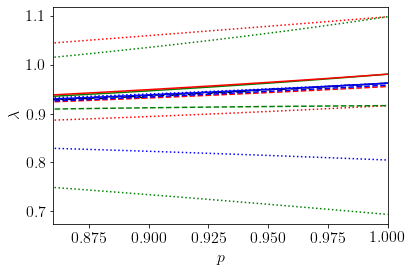

In [100]:
ps = np.arange(0.7,1.0,0.01)
pss = np.arange(0.7,1.0,0.001)
pl.xlim([0.86,1.0])
pl.plot(pss,les,'k')
pl.plot(ps,L1lows,'r:')
pl.plot(ps,L1highs,'r:')
pl.plot(ps,L2lows,'b:')
pl.plot(ps,L2highs,'b:')
pl.plot(ps,Linflows,'g:')
pl.plot(ps,Linfhighs,'g:')
pl.plot(ps,Linflows_improved,'g--')
pl.plot(ps,Linfhighs_improved,'g')
pl.plot(ps,L1lows_improved,'r')
pl.plot(ps,L1highs_improved,'r--')
pl.plot(ps,L2lows_improved,'b--')
pl.plot(ps,L2highs_improved,'b')
pl.xlabel(r'$p$',fontsize=16)
pl.ylabel(r'$\lambda$',fontsize=16)
pl.savefig('ltm_better_bounds.pdf')

Plot instead the size of the envelope (the difference between upper and lower bounds) for both the original and improved bounds. This is figure 6a of the paper:

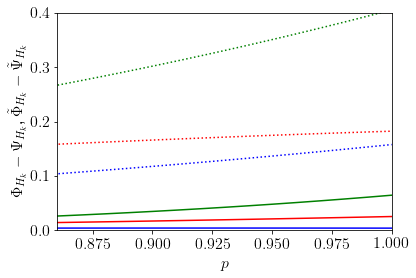

In [103]:
ps = np.arange(0.7,1.0,0.01)
pss = np.arange(0.7,1.0,0.001)
pl.xlim([0.86,1.0])
pl.ylim([0.0,0.4])
pl.plot(ps, [m - n for m,n in zip(L1highs,L1lows)],'r:')
pl.plot(ps, [m - n for m,n in zip(L2highs,L2lows)],'b:')
pl.plot(ps, [m - n for m,n in zip(Linfhighs,Linflows)],'g:')
pl.plot(ps, [m - n for m,n in zip(L1lows_improved,L1highs_improved)],'r')
pl.plot(ps, [m - n for m,n in zip(L2highs_improved,L2lows_improved)],'b')
pl.plot(ps, [m - n for m,n in zip(Linfhighs_improved,Linflows_improved)],'g')
pl.xlabel(r'$p$',fontsize=16)
pl.ylabel(r'$\Phi_{H_k}-\Psi_{H_k}$, $\tilde{\Phi}_{H_k}-\tilde{\Psi}_{H_k}$',fontsize=16)
pl.savefig('ltm_better_bounds.pdf', bbox_inches='tight')

Focus on the tightest pair of bounds, and compare to the numerically calculated approximation, as in figure 6(b):

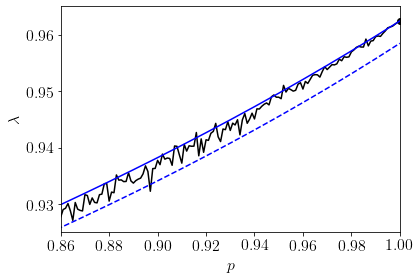

In [116]:
ps = np.arange(0.7,1.0,0.01)
pss = np.arange(0.7,1.0,0.001)
pl.xlim([0.86,1.0])
pl.ylim([0.925,0.965])
pl.plot(pss,les,'k')
pl.plot(ps,L2lows_improved,color="blue",linestyle='dashed')
pl.plot(ps,L2highs_improved,color="blue")
pl.scatter(1.0,np.log(np.max(np.linalg.eigvals(np.array([[2,1],[1,1]])))),c='k')
pl.xlabel(r'$p$',fontsize=16)
pl.ylabel(r'$\lambda$',fontsize=16)
pl.tight_layout()
pl.savefig('ltm_better_bounds_zoom.pdf')

## Generalised Lyapunov exponents

Generalised Lyapunov exponents can be bounded using the same functions already defined:

In [125]:
def gle_L1_lower_bound(p,q):
    tot = R11(p)*L1min(1,1,p)**q + R12(p)*L1min(1,2,p)**q + R21(p)*L1min(2,1,p)**q
    tot += R22(p)*L1min(2,2,p)**q
    for a in range(3,1000):
        tot += 2*R1n(p,a)*L1min(1,a,p)**q
    return np.log(tot)/ns(p)

def gle_L1_upper_bound(p,q):
    tot = R11(p)*L1max(1,1,p)**q+R12(p)*L1max(1,2,p)**q+R21(p)*L1max(2,1,p)**q
    tot += R22(p)*L1max(2,2,p)**q
    for a in range(3,1000):
        tot += 2*R1n(p,a)*L1max(1,a,p)**q
    return np.log(tot)/ns(p)

def gle_L2_lower_bound(p,q):
    tot = R11(p)*L2min(1,1,p)**q+R12(p)*L2min(1,2,p)**q+R21(p)*L2min(2,1,p)**q
    tot += R22(p)*L2min(2,2,p)**q
    for a in range(3,1000):
        tot += 2*R1n(p,a)*L2min(1,a,p)**q
    return np.log(tot)/ns(p)

def gle_L2_upper_bound(p,q):
    tot = R11(p)*L2max(1,1,p)**q+R12(p)*L2max(1,2,p)**q+R21(p)*L2max(2,1,p)**q
    tot += R22(p)*L2max(2,2,p)**q
    for a in range(3,1000):
        tot += 2*R1n(p,a)*L2max(1,a,p)**q
    return np.log(tot)/ns(p)

def gle_Linf_lower_bound(p,q):
    tot = R11(p)*Linfmin(1,1,p)**q+R12(p)*Linfmin(1,2,p)**q+R21(p)*Linfmin(2,1,p)**q
    tot += R22(p)*Linfmin(2,2,p)**q
    for a in range(3,1000):
        tot += 2*R1n(p,a)*Linfmin(1,a,p)**q
    return np.log(tot)/ns(p)

def gle_Linf_upper_bound(p,q):
    tot = R11(p)*Linfmax(1,1,p)**q+R12(p)*Linfmax(1,2,p)**q+R21(p)*Linfmax(2,1,p)**q
    tot += R22(p)*Linfmax(2,2,p)**q
    for a in range(3,1000):
        tot += 2*R1n(p,a)*L1max(1,a,p)**q
    return np.log(tot)/ns(p)

In [126]:
gle_l1_low = []
gle_l1_high = []
gle_l2_low = []
gle_l2_high = []
gle_linf_low = []
gle_linf_high = []
for q in np.arange(-5,5,0.2):
    gle_l1_low.append(gle_L1_lower_bound(0.8,q))
    gle_l1_high.append(gle_L1_upper_bound(0.8,q))
    gle_l2_low.append(gle_L2_lower_bound(0.8,q))
    gle_l2_high.append(gle_L2_upper_bound(0.8,q))
    gle_linf_low.append(gle_Linf_lower_bound(0.8,q))
    gle_linf_high.append(gle_Linf_upper_bound(0.8,q))

Plot figure 7 with the tightest bounds (from the $l_2$ norm), including the topological entropy at $q=1$:

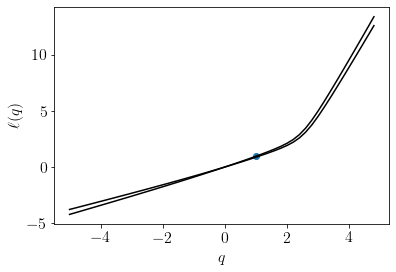

In [127]:
pl.plot(np.arange(-5,5,0.2),gle_l2_low,'k')
pl.plot(np.arange(-5,5,0.2),gle_l2_high,'k')
pl.scatter(1.0,top_entropy_bound(0.8))
pl.xlabel(r'$q$',fontsize=16)
pl.ylabel(r'$\ell(q)$',fontsize=16)
pl.savefig('ltm_gle.pdf', bbox_inches="tight")